In [1]:
import pandas as pd
import numpy as np
import pickle

In [2]:
X_train, y_train = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210130_TRAIN_final.pkl')

FileNotFoundError: [Errno 2] No such file or directory: './data/pickle/preproc/df_patient_admit_icu__20210130_TRAIN_final.pkl'

# SAMEDAY ICU

In [3]:
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from customTransformers import (ColumnSelectTransformer, DiagnosisFrameTransformer, 
                                EstimatorTransformer, LinearNonlinear, ColumnMergeTransformer
                               )
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.metrics import plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor

In [8]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']

num_cols = ['ADMIT_AGE']
demog_feats1 = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])
demog_pipe1 = Pipeline([
    ('features', demog_feats1),
    ('reg', LogisticRegression(solver='liblinear'))
])
demog_params1 = {
    'reg__penalty': ['l1','l2','none'],
    'reg__C': [0.01, 0.1, 1, 10],
    'reg__class_weight': ['none','balanced'],
}

# lin_gs_regressor1 = GridSearchCV(demog_pipe1, demog_params1, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
# lin_est1 = lin_gs_regressor1.fit(X_train,X_train['SAMEDAY_ADM_TO_ICU'])

In [11]:
lin_est1.best_params_,lin_est1.best_score_

({'reg__C': 0.1, 'reg__class_weight': 'balanced', 'reg__penalty': 'l2'},
 0.5722280875294657)

In [5]:
diagn_pipe1b = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])

diagn_params1b = {
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__min_samples_split': [2,5,8,11],
    'rfc__min_samples_leaf': [1,4,7],
    'rfc__class_weight': ['balanced', 'balanced_subsample'],
}

diagn_gs_regressor1b = GridSearchCV(diagn_pipe1b, diagn_params1b, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=10)
tfidf_est1b = diagn_gs_regressor1b.fit(X_train,X_train['SAMEDAY_ADM_TO_ICU'])

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  12 tasks      | elapsed:   49.6s
[Parallel(n_jobs=10)]: Done 108 tasks      | elapsed:  2.5min
[Parallel(n_jobs=10)]: Done 268 tasks      | elapsed:  6.3min
[Parallel(n_jobs=10)]: Done 492 tasks      | elapsed: 11.8min
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=10)]: Done 720 out of 720 | elapsed: 16.5min finished


In [6]:
tfidf_est1b.best_params_,tfidf_est1b.best_score_

({'rfc__class_weight': 'balanced_subsample',
  'rfc__criterion': 'entropy',
  'rfc__max_features': 'log2',
  'rfc__min_samples_leaf': 1,
  'rfc__min_samples_split': 2},
 0.7360997577172081)

In [9]:
demog_est1c = LogisticRegression(solver='liblinear', C=0.1, class_weight='balanced', penalty='l2')
demog_pipe1c = Pipeline([
    ('features', demog_feats1),
    ('reg', demog_est1c)
])

diagn_est1c = RandomForestClassifier(class_weight='balanced_subsample',criterion='entropy',
                                  max_features='log2',min_samples_leaf=1,
                                  min_samples_split=2)
diagn_pipe1c = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', diagn_est)
])

union1c = FeatureUnion([
    ('demog', EstimatorTransformer(demog_pipe1c)),# FeatureUnions use the same syntax as Pipelines
    ('diagn',EstimatorTransformer(diagn_pipe1c))
])


full_pipe1c = Pipeline([
    ('union',union1c),
    ('xgb', GradientBoostingClassifier())
])

xgb_params1c = {
    'xgb__loss': ['deviance','exponential'],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__subsample': [0.8, 1, 1.2], # max is 1
    'xgb__criterion': ['mse','friedman_mse'],
    'xgb__min_samples_leaf': [1,4,7],
    'xgb__max_depth': [2,3,4,5],
    'xgb__max_features': ['auto','log2',None]
}

xgb_gs_classifier1c = GridSearchCV(full_pipe1c, xgb_params1c, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=12)
xgb_est1c = xgb_gs_classifier1c.fit(X_train,X_train['SAMEDAY_ADM_TO_ICU'])

xgb_est1c.best_params_,xgb_est1c.best_score_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:   53.8s
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:  8.2min
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed: 52.7min
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed: 554.2min
[Parallel(n_jobs=12)]: Done 776 tasks      | elapsed: 576.0min
[Parallel(n_jobs=12)]: Done 1128 tasks      | elapsed: 602.4min
[Parallel(n_jobs=12)]: Done 1544 tasks      | elapsed: 640.9min
[Parallel(n_jobs=12)]: Done 2024 tasks      | elapsed: 682.8min
[Parallel(n_jobs=12)]: Done 2568 tasks      | elapsed: 730.6min
[Parallel(n_jobs=12)]: Done 3176 tasks      | elapsed: 784.4min
[Parallel(n_jobs=12)]: Don

({'xgb__criterion': 'mse',
  'xgb__learning_rate': 0.05,
  'xgb__loss': 'exponential',
  'xgb__max_depth': 4,
  'xgb__max_features': 'auto',
  'xgb__min_samples_leaf': 4,
  'xgb__subsample': 0.8},
 0.761460606507654)

In [11]:
X_test, y_test = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210126_TEST_final.pkl')

In [50]:
y_pred = xgb_est1c.predict(X_test)
print(confusion_matrix(X_test['SAMEDAY_ADM_TO_ICU'],y_pred))
print(accuracy_score(X_test['SAMEDAY_ADM_TO_ICU'],y_pred))
print(f1_score(X_test['SAMEDAY_ADM_TO_ICU'],y_pred))

[[1163 1659]
 [1306 8066]]
0.7568476299819583
0.844740011520134


Text(0.5, 1.0, '2-class Precision-Recall curve: AP=0.86')

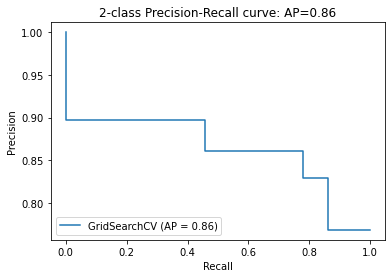

In [18]:
y_score = xgb_est1c.decision_function(X_test)
average_precision = average_precision_score(X_test['SAMEDAY_ADM_TO_ICU'], y_score)

disp = plot_precision_recall_curve(xgb_est, X_test, X_test['SAMEDAY_ADM_TO_ICU'])
disp.ax_.set_title('2-class Precision-Recall curve: '
                   'AP={0:0.2f}'.format(average_precision))

In [21]:
file = './data/pickle/models/log_rf_xgb__SAMEDAY__20210127.pkl'
pickle.dump((demog_pipe1c, diagn_pipe1c, xgb_est1c),open(file,'wb'))

In [103]:
y_pred = xgb_est.predict(X_test)

corr_sum = sum((y_pred==1) & (y_pred==X_test['SAMEDAY_ADM_TO_ICU']))
incorr_sum = sum((y_pred==0) & (y_pred!=X_test['SAMEDAY_ADM_TO_ICU'])
total = corr_sum+incorr_sum

correct=np.mean(days_adm_icu[(y_pred==1) & (y_pred==X_test['SAMEDAY_ADM_TO_ICU'])])*24
incorrect=np.mean(days_adm_icu[(y_pred==0) & (y_pred!=X_test['SAMEDAY_ADM_TO_ICU'])])*24

hours_saved = (corr_sum/total)*correct - (incorr_sum/total)*incorrect
minutes_saved = hours_saved*60
minutes_saved

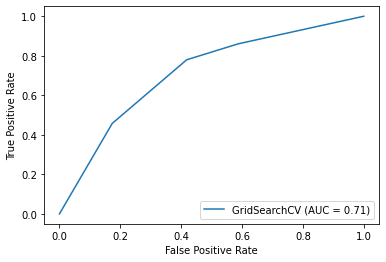

In [106]:
plot_roc_curve(xgb_est, X_test, X_test['SAMEDAY_ADM_TO_ICU'])

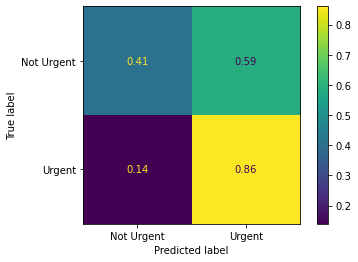

In [114]:
plot_confusion_matrix(xgb_est, X_test, X_test['SAMEDAY_ADM_TO_ICU'],display_labels=['Not Urgent', 'Urgent'],normalize='true')

# ICU URGENCY SCORE

In [38]:
## TRYING TO IMPLEMENT 4 OVR CLASSIFICATION SYSTEMS FOR ICU_URGENCY.
# 1. CREATE AND TUNE OVR for demographics
# 2. use multinomial classifier for diagnoses
# 3. use all 5 outputs as features in a second multinomial to pool results
from sklearn.preprocessing import OrdinalEncoder

cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']

num_cols = ['ADMIT_AGE']
demog_feats1 = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])

demog_pipe1 = Pipeline([
    ('features', demog_feats1),
    ('reg', LogisticRegression(solver='saga'))
])
demog_params1 = {
    'reg__penalty': ['l1','l2','none'],
    'reg__C': [0.01, 0.1, 1, 10],
    'reg__class_weight': ['none','balanced'],
    'reg__multi_class': ['ovr','multinomial'],
}

ordenc = OrdinalEncoder(categories=[['stable','questionable','urgent','immediate']])
y_train_enc = ordenc.fit_transform(y_train.to_numpy().reshape(-1,1))
lin_gs_classifier1 = GridSearchCV(demog_pipe1, demog_params1, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
lin_est1 = lin_gs_classifier1.fit(X_train,y_train_enc)

lin_est1.best_params_,lin_est1.best_score_

In [ ]:
diagn_pipe1 = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', RandomForestClassifier())
])

diagn_params1 = {
    'rfc__criterion': ['gini','entropy'],
    'rfc__max_features': ['auto', 'sqrt', 'log2'],
    'rfc__min_samples_split': [2,5,8,11],
    'rfc__min_samples_leaf': [1,4,7],
    'rfc__class_weight': ['balanced', 'balanced_subsample'],
}

diagn_gs_classifier1 = GridSearchCV(diagn_pipe1, diagn_params1, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=4)
tfidf_est1 = diagn_gs_classifier1.fit(X_train,y_train_enc)
tfidf_est1.best_params_,tfidf_est1.best_score_

In [ ]:


demog_est1 = LogisticRegression(solver='saga', C=0.1, class_weight='none', 
                               penalty='l2', multi_class='ovr')
demog_pipe1 = Pipeline([
    ('features', demog_feats),
    ('reg', demog_est1)
])

diagn_est1 = RandomForestClassifier(class_weight='balanced',criterion='gini',
                                  max_features='sqrt',min_samples_leaf=1,
                                  min_samples_split=2)
diagn_pipe1 = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfc', diagn_est1)
])

union1 = FeatureUnion([
    ('demog', EstimatorTransformer(demog_pipe1)),# FeatureUnions use the same syntax as Pipelines
    ('diagn',EstimatorTransformer(diagn_pipe1))
])


full_pipe1 = Pipeline([
    ('union',union1),
    ('xgb', GradientBoostingClassifier())
])

xgb_params1 = {
    'xgb__loss': ['deviance','exponential'],
    'xgb__learning_rate': [0.05, 0.1, 0.2],
    'xgb__subsample': [0.8, 1], # max is 1
    'xgb__criterion': ['friedman_mse'],
    'xgb__min_samples_leaf': [1, 4, 7],
    'xgb__max_depth': [2,3,4],
    'xgb__max_features': ['auto']
}

xgb_gs_classifier1 = GridSearchCV(full_pipe1, xgb_params1, cv=StratifiedKFold(n_splits=3, shuffle=True),verbose=3,n_jobs=4)
xgb_est1 = xgb_gs_classifier1.fit(X_train,y_train_enc)

xgb_est1.best_params_,xgb_est1.best_score_

In [75]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']
num_cols = ['ADMIT_AGE']

demog_feats = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])
diagn_feats = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer())
])

feats_union = FeatureUnion([
    ('demog_feats', demog_feats),
    ('diagn_feats', diagn_feats)
])

lin_pipe = Pipeline([
    ('features', feats_union),
    ('reg', LogisticRegression(solver='saga'))
])

lin_params = {
    'reg__penalty': ['l1','l2','none'],
    'reg__C': [0.01, 0.1, 1, 10],
    'reg__class_weight': ['none','balanced'],
    'reg__multi_class': ['ovr','multinomial'],
}

ordenc = OrdinalEncoder(categories=[['stable','questionable','urgent','immediate']])
y_train_enc = ordenc.fit_transform(y_train.to_numpy().reshape(-1,1))
lin_gs_classifier = GridSearchCV(lin_pipe, lin_params, cv=StratifiedKFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
lin_est = lin_gs_classifier.fit(X_train,y_train_enc)

lin_est.best_params_,lin_est.best_score_

Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  96 tasks      | elapsed:   50.0s
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=-1)]: Done 240 out of 240 | elapsed:  6.1min finished
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/adamgifford/anaconda3

({'reg__C': 1,
  'reg__class_weight': 'none',
  'reg__multi_class': 'ovr',
  'reg__penalty': 'l2'},
 0.6449278478945732)

In [76]:
y_test_enc = ordenc.transform(y_test.to_numpy().reshape(-1,1))
y_pred = lin_est.predict(X_test)
print(confusion_matrix(y_test_enc,y_pred))
print(accuracy_score(y_test_enc,y_pred))
print(f1_score(y_test_enc,y_pred, average='weighted'))

[[ 121  143  141  744]
 [  88  305  298  982]
 [  51  176 1052 1359]
 [  52  168  111 6403]]
0.6463014597342955
0.5928604185555643


In [77]:
file = './data/pickle/models/log__URGENCY__20210130.pkl'
pickle.dump(lin_est,open(file,'wb'))

In [ ]:
y_test_enc = ordenc.transform(y_test.to_numpy().reshape(-1,1))
y_pred = xgb_est1.predict(X_test)
print(confusion_matrix(y_test_enc,y_pred))
print(accuracy_score(y_test_enc,y_pred))
print(f1_score(y_test_enc,y_pred, average='weighted'))

In [ ]:
file = './data/pickle/models/log_rf_xgb__URGENCY__20210127.pkl'
pickle.dump((demog_pipe1, diagn_pipe1, xgb_est1),open(file,'wb'))

# Length of stay

## modeling separately

In [4]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']
num_cols = ['ADMIT_AGE']

demog_feats2 = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)]))
])
demog_pipe2 = Pipeline([
    ('features', demog_feats2),
    ('ridge', Ridge())
])
demog_params2 = {
    'ridge__alpha': (0.01, 0.1, 1, 10, 100),
    'ridge__normalize': ('uniform', 'distance'),
    'ridge__fit_intercept': (True, False)
}
simp = SimpleImputer(strategy='median')
y_train_imp = simp.fit(X_train[['LOS']]).transform(X_train[['LOS']])
lin_gs_regressor2 = GridSearchCV(demog_pipe2, demog_params2, cv=KFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
lin_est2 = lin_gs_regressor2.fit(X_train,y_train_imp)
lin_est2.best_params_,lin_est2.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    5.5s finished


({'ridge__alpha': 1,
  'ridge__fit_intercept': False,
  'ridge__normalize': 'uniform'},
 0.09518435501757001)

In [11]:
diagn_pipe2 = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
    ('rfr', RandomForestRegressor(n_estimators=50))
])

diagn_params2 = {
    'rfr__criterion': ['mse','mae'],
    'rfr__max_features': ['sqrt', 'log2'],
    'rfr__min_samples_split': [0.2,0.225, 0.25],
    'rfr__min_samples_leaf': [0.01, 0.02, 0.03],
#     'rfr__ccp_alpha': [0,0.5,1],
    'rfr__max_depth': [35, 40, 45, 50]
}
# y_train_imp.values.ravel() --> DataConversionWarning: A column-vector y was passed
##                       when a 1d array was expected. Please change the shape of y to 
##                       (n_samples,), for example using ravel().
diagn_gs_classifier2 = GridSearchCV(diagn_pipe2, diagn_params2, cv=KFold(n_splits=5, shuffle=True),verbose=3,n_jobs=12)
tfidf_est2 = diagn_gs_classifier2.fit(X_train,y_train_imp.ravel())
tfidf_est2.best_params_,tfidf_est2.best_score_

Fitting 5 folds for each of 144 candidates, totalling 720 fits


[Parallel(n_jobs=12)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done   8 tasks      | elapsed:    3.0s
[Parallel(n_jobs=12)]: Done 104 tasks      | elapsed:   10.5s
[Parallel(n_jobs=12)]: Done 264 tasks      | elapsed:   24.3s
/Users/adamgifford/anaconda3/lib/python3.8/site-packages/joblib/externals/loky/process_executor.py:688: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[Parallel(n_jobs=12)]: Done 488 tasks      | elapsed: 10.7min
[Parallel(n_jobs=12)]: Done 720 out of 720 | elapsed: 25.4min finished


({'rfr__criterion': 'mse',
  'rfr__max_depth': 40,
  'rfr__max_features': 'sqrt',
  'rfr__min_samples_leaf': 0.01,
  'rfr__min_samples_split': 0.225},
 0.005239045801969722)

## linear/nonlinear model fitting both simultaneously

In [74]:
cols = ['GENDER','ADMISSION_TYPE','ADMISSION_LOCATION','INSURANCE','LANGUAGE',
       'RELIGION','MARITAL_STATUS','ETHNICITY']
num_cols = ['ADMIT_AGE']

diagn_feats = Pipeline([
    ('cst', ColumnSelectTransformer(['DIAGNOSIS'])),
    ('dst', DiagnosisFrameTransformer()),
    ('count',CountVectorizer(max_features=3000)),
    ('tfid', TfidfTransformer()),
])

all_feats = FeatureUnion([
    ('stdscl', ColumnTransformer([('numerical', StandardScaler(), num_cols)])),
    ('ohe',  ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)])),
    ('diagn', diagn_feats)
])

all_pipe_a = Pipeline([
    ('features', all_feats),
    ('ridge', Ridge())
])

all_params3a = {
    'ridge__alpha': (0.01, 0.1, 1, 10, 100),
    'ridge__normalize': ('uniform', 'distance'),
    'ridge__fit_intercept': (True, False)
}
simp = SimpleImputer(strategy='median')
y_train_imp = simp.fit(X_train[['LOS']]).transform(X_train[['LOS']])
lin_gs_regressor3 = GridSearchCV(all_pipe_a, all_params3a, cv=KFold(n_splits=5, shuffle=True),verbose=3,n_jobs=-1)
lin_est3 = lin_gs_regressor3.fit(X_train,y_train_imp)
lin_est3.best_params_,lin_est3.best_score_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.8s finished


({'ridge__alpha': 10,
  'ridge__fit_intercept': False,
  'ridge__normalize': 'uniform'},
 0.10842094596107854)

In [7]:
all_pipe_b = Pipeline([
    ('features', all_feats),
    ('rfr', RandomForestRegressor(n_estimators=75))
])

all_params3b = {
    'rfr__criterion': ['mse','mae'],
    'rfr__max_features': ['sqrt', 'log2'],
    'rfr__min_samples_split': [0.2, 0.225, 0.25],
    'rfr__min_samples_leaf': [0.0075, 0.01, 0.02, 0.03],
    'rfr__ccp_alpha': [0, 0.5, 1],
    'rfr__max_depth': [30, 35, 40, 45, 50, 55]
}
simp = SimpleImputer(strategy='median')
y_train_imp = simp.fit(X_train[['LOS']]).transform(X_train[['LOS']])
nl_gs_regressor3 = GridSearchCV(all_pipe_b, all_params3b, cv=KFold(n_splits=5, shuffle=True),verbose=3,n_jobs=6)
nl_est3 = nl_gs_regressor3.fit(X_train,y_train_imp.ravel())
nl_est3.best_params_,nl_est3.best_score_

In [11]:
nl_est3.best_params_,nl_est3.best_score_

({'rfr__ccp_alpha': 0,
  'rfr__criterion': 'mse',
  'rfr__max_depth': 45,
  'rfr__max_features': 'sqrt',
  'rfr__min_samples_leaf': 0.0075,
  'rfr__min_samples_split': 0.2},
 0.0290428004774425)

In [14]:
linreg = Ridge(alpha=10,normalize ='uniform', fit_intercept=False)
nonlinreg = RandomForestRegressor(n_estimators=75, criterion='mse',
                                  max_depth=45,min_samples_leaf=0.0075,
                                  min_samples_split=0.2, max_features = 'sqrt')
regressor = LinearNonlinear(lin=linreg,nonlin=nonlinreg)
l_nl_pipe = Pipeline([
        ('features', all_feats), # features
        ('regressor', regressor) # Ridge' + RandomForest
    ])
y_train_imp = simp.fit(X_train[['LOS']]).transform(X_train[['LOS']])
l_nl_est4 = l_nl_pipe.fit(X_train,y_train_imp.ravel())

In [17]:
score = l_nl_est4.score(X_train,y_train_imp.ravel())
score

0.12740024567731567

In [168]:
from bokeh.io import output_notebook, show
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

In [21]:
file = './data/pickle/models/log_rf_xgb__URGENCY__20210127.pkl'
urg_demog_pipe, urg_diagn_pipe, urg_est = pickle.load(open(file,'rb'))
X_test, y_test = pd.read_pickle('./data/pickle/preproc/df_patient_admit_icu__20210126_TEST_final.pkl')

In [25]:
from sklearn.preprocessing import OrdinalEncoder
ordenc = OrdinalEncoder(categories=[['stable','questionable','urgent','immediate']])
y_train_enc = ordenc.fit_transform(y_train.to_numpy().reshape(-1,1))
y_test_enc = ordenc.transform(y_test.to_numpy().reshape(-1,1))
y_pred = urg_est.predict(X_test)
y_pred_proba = urg_est.predict_proba(X_test)

In [26]:
y_pred_proba[0]

array([0.81543065, 0.0492553 , 0.03016013, 0.10515393])

In [123]:
y_pred = lin_est.predict(X_test)
y_pred_proba = lin_est.predict_proba(X_test)

In [152]:
from bokeh.palettes import Spectral4

factors = ['stable','questionable','urgent','immediate']
probs = y_pred_proba[10]
source = ColumnDataSource(data=dict(factors=factors, probs=probs, color=Spectral4))

p = figure(x_range=factors, plot_height=250, title="IC-U Risk Factor",
           plot_width=300, toolbar_location=None, tools="")

p.vbar(x='factors', top='probs', color='color', width=0.4, source=source)
# (x='fruits', top='counts', width=0.9, color='color', legend_field="fruits", source=source)

p.xgrid.grid_line_color = None
p.y_range.start = 0
p.yaxis.axis_label = 'P(category)'

show(p)

<AxesSubplot:>

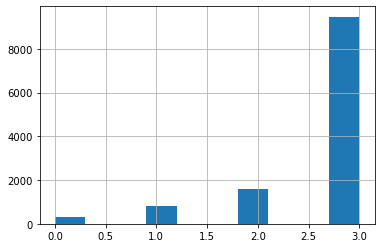

In [56]:
pd.Series(y_pred).hist()

In [78]:
len(lin_est.best_estimator_.named_steps.reg.coef_[3])

3126

In [79]:
lin_est.best_estimator_.named_steps.features.transformer_list

[('demog_feats',
  FeatureUnion(transformer_list=[('stdscl',
                                  ColumnTransformer(transformers=[('numerical',
                                                                   StandardScaler(),
                                                                   ['ADMIT_AGE'])])),
                                 ('ohe',
                                  ColumnTransformer(transformers=[('categorical',
                                                                   OneHotEncoder(handle_unknown='ignore'),
                                                                   ['GENDER',
                                                                    'ADMISSION_TYPE',
                                                                    'ADMISSION_LOCATION',
                                                                    'INSURANCE',
                                                                    'LANGUAGE',
                                           

In [92]:
def getFeatureNames(numerical,categorical,bow):
    feature_names = numerical
    feature_names.extend([c.split('_')[-1] for c in categorical.get_feature_names()])
    feature_names.extend(bow.get_feature_names())
    
    return feature_names

In [69]:
foo = feats_union.fit_transform(X_train)

In [80]:
bar = ColumnTransformer([('categorical', OneHotEncoder(handle_unknown='ignore'), cols)])
bar.fit_transform(X_train)

<48776x125 sparse matrix of type '<class 'numpy.float64'>'
	with 390208 stored elements in Compressed Sparse Row format>

In [90]:
bar.get_feature_names()[0].split('_')[-1]

'F'

In [94]:
feature_names = getFeatureNames(['ADMIT_AGE'],bar,baz)

In [95]:
len(feature_names)

3126

In [141]:
def createFeatureCoeffDict(coef,features):
    feats_coeff = [(f, c) for c,f in zip(coef,features)]
    return feats_coeff

In [138]:
len(x_test[0].toarray()[0])

3126

In [142]:
feature_importance = createFeatureCoeffDict(lin_est.best_estimator_.named_steps.reg.coef_[0],feature_names)

In [146]:
feats_union.fit(X_train)
x_test = feats_union.transform(X_test)
xtest0 = x_test[0].toarray()[0]
features_scores = [(f[0], x * f[1]) for x,f in zip(xtest0,feature_importance)]
most_important = sorted(features_scores, key=lambda x: -abs(x[1]))

In [150]:
most_important[:5]

[('NEWBORN', -1.9359744914915578),
 ('newborn', -1.732725484874877),
 ('F', -0.8878545151738019),
 ('CLINIC REFERRAL/PREMATURE', -0.46512602580238843),
 ('UNKNOWN (DEFAULT)', -0.4110579917380167)]

In [ ]:
p.h

In [166]:
import numpy as np

from bokeh.io import curdoc, show
from bokeh.models import ColumnDataSource, Grid, HBar, LinearAxis, Plot

y = [m[0] for m in most_important[:4]]
x = [abs(m[1]) for m in most_important[:4]]
x = [val/np.round(max(x)) for val in x]

source = ColumnDataSource(dict(factors=y, scores=x,))

p = figure(y_range=y, plot_height=250, title="Main Factors",
           plot_width=400, toolbar_location=None, tools="")

p.hbar(y='factors', right='scores', height=0.4, source=source)

p.ygrid.grid_line_color = None
p.x_range.start = 0
p.xaxis.axis_label = 'Score'

show(p)

In [159]:
source.data

{'factors': ['NEWBORN', 'newborn', 'F', 'CLINIC REFERRAL/PREMATURE'],
 'scores': [0.9679872457457789,
  0.8663627424374385,
  0.44392725758690094,
  0.23256301290119422]}